In [ ]:
!pip install -q \
  transformers==4.57.3 \
  peft \
  bitsandbytes \
  accelerate \
  datasets \
  loralib \
  sentencepiece

In [ ]:
# Imports
import pandas as pd
import numpy as np
import json
import ast
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
)
from tqdm import tqdm
import sklearn.metrics
import matplotlib.pyplot as plt



## Load in Model:
Using GPU, this will help us generate faster responses

In [ ]:
# Check if connected to GPU Runtime for generating responses:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
  print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 1
GPU name: NVIDIA A100-SXM4-40GB


In [ ]:
## Load in the MediPhi Model
MODEL_NAME = "microsoft/MediPhi"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
  MODEL_NAME,
  torch_dtype=torch.float16,
  device_map="cuda"
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Applying LoRA

Some code I took from this Notebook to Guide me through this

https://colab.research.google.com/drive/14xo6sj4dARk8lXZbOifHEn1f_70qNAwy?usp=sharing#scrollTo=T-gy-LxM0yAi

### Freezing Model Weights

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Setting Up LoRA Adapters

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules= "all-linear"
)

In [ ]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 12,864,000 || all params: 3,833,943,552 || trainable%: 0.3355


## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_label_to_dict(entry: str) -> dict:
    return ast.literal_eval(entry)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/processed_data_all_entities.csv')
# edema_df
edema_df = data.copy()[['Accession', 'Radiologist_Report', 'Edema', 'Train/Test/Val' ]]
# parse the labels column into dictionaries
edema_df['Edema'] = edema_df['Edema'].apply(convert_label_to_dict)

In [ ]:
# Load prompt
try:
    with open('/content/drive/MyDrive/Edema_short.txt') as f:
        prompt = f.read()
except:
    print('FileNotFoundError')

In [ ]:
def format_training_strings(report, label, edema_prompt=prompt):
  return f"""
  {edema_prompt}
  {report}
  ### Response:
  {label}
  """.strip()

In [ ]:
edema_df["training_text"] = edema_df.apply(
    lambda row: format_training_strings(
        edema_prompt=prompt,
        report=row["Radiologist_Report"],
        label=row["Edema"],
    ),
    axis=1,
)

In [ ]:
edema_df.iloc[0]['training_text']

'You are a radiologist’s assistant bot. Extract and report structured information related to [pulmonary edema] from the following chest X-ray report.\n\nRespond strictly in the following format. Use only the options listed below. Do not add extra words, explanations, or categories.\n\nReturn your final output as a dictionary with the following keys:\n"Presence", "Severity", and "Change"\nEach key should map to a string.\n\nExample output format:\n{\n"Presence": "present",\n"Severity": "moderate",\n"Change": "increased"\n}\n\nValid options:\n\nPresence:\npresent\nabsent\nunknown\n\nSeverity:\nNA\ntrace\nmild\nmoderate\nsevere\nunknown\n\nChange:\nstable\nincreased\ndecreased\nunknown\nNA\n\nGuidelines:\n\n- If pulmonary edema is explicitly ruled out or the lungs are described as clear, set "Presence" to "absent" and set both "Severity" and "Change" to "NA".\n- Findings such as peribronchial cuffing, Kerley B lines, perihilar opacities, or reticular opacities may suggest edema but are no

In [ ]:
train_df = edema_df[edema_df['Train/Test/Val'] == 'training']
val_df = edema_df[edema_df['Train/Test/Val'] == 'validation']
test_df = edema_df[edema_df['Train/Test/Val'] == 'testing']
print(len(train_df), len(val_df), len(test_df))

500 100 2889


In [ ]:
def tokenize_and_mask(example):
    text = example["training_text"]

    tokenized = tokenizer(
        text,
        truncation=True,
        max_length=1024, # Reduced max_length to save memory
        padding=False,
    )

    input_ids = tokenized["input_ids"]
    labels = input_ids.copy()

    response_marker = "### Response:"
    marker_ids = tokenizer(
        response_marker,
        add_special_tokens=False
    )["input_ids"]

    start_idx = None
    for i in range(len(input_ids) - len(marker_ids) + 1):
        if input_ids[i:i + len(marker_ids)] == marker_ids:
            start_idx = i + len(marker_ids)
            break

    if start_idx is None:
        # Ignore entire example if malformed
        labels = [-100] * len(input_ids)
    else:
        labels[:start_idx] = [-100] * start_idx

    return {
        "input_ids": input_ids,
        "attention_mask": tokenized["attention_mask"],
        "labels": labels,
    }


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(
    tokenize_and_mask,
    remove_columns=train_dataset.column_names,
)

val_dataset = val_dataset.map(
    tokenize_and_mask,
    remove_columns=val_dataset.column_names,
)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

## Training

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# 1) IDs
base_model_id = "microsoft/MediPhi"
adapter_model_id = "brianthuynh/mediphi-LoRA-Edema"

# 2) Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

# 3) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 4) Attach adapter
model = PeftModel.from_pretrained(model, adapter_model_id)

model.eval()
print("Loaded:", type(model))
print("dtype:", next(model.parameters()).dtype)
print("device:", next(model.parameters()).device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 188.00 MiB. GPU 0 has a total capacity of 39.49 GiB of which 161.44 MiB is free. Including non-PyTorch memory, this process has 39.32 GiB memory in use. Of the allocated memory 37.61 GiB is allocated by PyTorch, and 1.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model_id = "microsoft/MediPhi"
adapter_model_id = "brianthuynh/mediphi-LoRA-Edema"

# 1) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2) Load base model in fp32 for training (IMPORTANT)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)
base_model.config.use_cache = False  # important for training

# 3) Attach adapter as TRAINABLE
model = PeftModel.from_pretrained(base_model, adapter_model_id, is_trainable=True)

# 4) Move to GPU (Trainer will handle fp16 with AMP if fp16=True in TrainingArguments)
model = model.to("cuda")
model.train()

# Sanity check: should be > 0
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trainable params: 12,582,912 / 3,833,662,464


In [ ]:
from transformers import TrainingArguments
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

training_args = TrainingArguments(
    output_dir="./mediphi-lora",
    per_device_train_batch_size=1, # Reduced from 2 to 1 to save memory
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,   # effective batch = 8 (1 * 8)
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",
)

In [ ]:
import gc, torch

# if you have old references, delete them
try:
    del trainer
except: pass
try:
    del model
except: pass

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [ ]:
from transformers import Trainer, BitsAndBytesConfig
from transformers import DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import gc

# Clear memory before attempting to load the model
gc.collect()
torch.cuda.empty_cache()

# Re-initialize model for training, as it was deleted in the previous cell.
# Use the same setup as in cell R0tVxF27ctcU
base_model_id = "microsoft/MediPhi"
adapter_model_id = "brianthuynh/mediphi-LoRA-Edema" # This is the adapter to be trained

tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # A100 GPUs support bfloat16
    bnb_4bit_use_double_quant=False,
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config, # Apply 4-bit quantization
    device_map={"": 0} # Explicitly map all layers to GPU 0 to prevent CPU/disk offload issues
)
base_model.config.use_cache = False

model = PeftModel.from_pretrained(base_model, adapter_model_id, is_trainable=True)
# When using device_map={"": 0} with quantization, the model is already on device.
# The Trainer will handle placing the trainable LoRA adapter parts on the GPU.
model.train() # Set to training mode

# 2. Use the Seq2Seq collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100 # Ensure padding is ignored in loss
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator= data_collator
)

trainer.train()

# The subsequent re-initialization of model in the original cell was removed
# as it was redundant and could cause issues if the checkpoint did not yet exist.
# The trainer.train() call is responsible for saving the checkpoints.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,0.022400,0.029184
2,0.015900,0.025544
3,0.008900,0.025006


TrainOutput(global_step=189, training_loss=0.01693130323968867, metrics={'train_runtime': 426.1591, 'train_samples_per_second': 3.52, 'train_steps_per_second': 0.443, 'total_flos': 2.1273703994732544e+16, 'train_loss': 0.01693130323968867, 'epoch': 3.0})

## Test Inference

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/MediPhi")
base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/MediPhi",
    torch_dtype=torch.float16,
    device_map="auto",
)

from peft import PeftModel

tuned_model = PeftModel.from_pretrained(
    base_model,
    "./mediphi-lora/checkpoint-189",   # Corrected path to the latest checkpoint
    device_map="cuda",
)

model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Phi3ForCausalLM(
      (model): Phi3Model(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3Attention(
              (o_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 1
GPU name: NVIDIA A100-SXM4-40GB


In [ ]:
def ask_llm_batch(reports, prompt, model=tuned_model):
    messages = [
        [{"role": "user", "content": prompt + report}]
        for report in reports
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True,
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=40,
            do_sample=False,
        )

    decoded = tokenizer.batch_decode(
        outputs[:, inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True,
    )

    # CLEAR UNUSED CUDA MEMORY
    del inputs, outputs
    torch.cuda.empty_cache()

    return [(d) for d in decoded]


In [ ]:
import torch

MAX_INPUT_TOKENS = 768   # safest for long reports; increase to 1024 if you can
MAX_NEW_TOKENS = 25

def ask_llm_batch(reports, prompt, model=tuned_model):
    messages = [[{"role": "user", "content": prompt + r}] for r in reports]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_INPUT_TOKENS,
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            do_sample=False,
            use_cache=True,
        )

    decoded = tokenizer.batch_decode(
        outputs[:, inputs["input_ids"].shape[-1]:],
        skip_special_tokens=True,
    )

    # free GPU
    del inputs, outputs
    torch.cuda.empty_cache()

    return decoded


In [ ]:
def make_predictions(prompt, df: pd.DataFrame, BATCH_SIZE: int):
    results = []

    total = len(df)
    for i in tqdm(
        range(0, total, BATCH_SIZE),
        desc="Running LLM inference",
        unit="reports",
    ):
        batch_reports = df["Radiologist_Report"].iloc[i:i + BATCH_SIZE].tolist()
        batch_results = ask_llm_batch(batch_reports, prompt)
        results.extend(batch_results)

    return results

In [ ]:
predictions_out = make_predictions(prompt, test_df, BATCH_SIZE=1)
# then try 2, then 4 if it fits


Running LLM inference: 100%|██████████| 2889/2889 [1:10:30<00:00,  1.46s/reports]


In [ ]:
import ast
import re

def extract_response_dict(text: str) -> dict | None:
    """
    Extracts the first Python-style dictionary from a model response string.

    Returns:
        dict if successful
        None if extraction or parsing fails
    """
    if not isinstance(text, str):
        return None

    # Match the first {...} block (non-greedy)
    match = re.search(r"\{.*?\}", text, re.DOTALL)

    if not match:
        return None

    dict_str = match.group(0)

    try:
        # Safely parse Python literal
        return ast.literal_eval(dict_str)
    except (SyntaxError, ValueError):
        return None


In [ ]:
clean_pred_out = [extract_response_dict(txt) for txt in predictions_out]
test_df['llm_predictions'] = clean_pred_out

/tmp/ipython-input-3312361243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['llm_predictions'] = clean_pred_out


## Evaluating Responses

In [ ]:
evalulate_cols = ['Edema', 'llm_predictions']
expanded_edema_df = pd.concat(
    [
        pd.json_normalize(test_df[col]).add_prefix(f"{col}_")
        for col in evalulate_cols
    ],
    axis=1
)

In [ ]:
expanded_edema_df.head()

,Edema_Presence,Edema_Severity,Edema_Change,llm_predictions_Presence,llm_predictions_Severity,llm_predictions_Change
0,present,moderate,stable,present,unknown,unknown
1,unknown,unknown,unknown,absent,NA,NA
2,absent,NA,NA,absent,NA,NA
3,unknown,unknown,stable,absent,NA,NA
4,present,mild,unknown,present,mild,unknown


In [ ]:
def map_results_for_prescence(label: str) -> str:
  LABEL_MAP = {
    # ABSENT
    "absent": "absent",
    "none": "absent",
    "no": "absent",
    "without": "absent",

    # PRESENT (positive edema)
    "present": "present",
    "mild": "present",
    "minimal": "present",
    "trace": "present",
    "borderline": "present",
    "possible": "present",
    "possible mild": "present",

    # UNCERTAIN
    "unknown": "unknown",
    "na": "unknown",
    "n/a": "unknown",
    "uncertain": "unknown"
  }
  if pd.isna(label): # Handle NaN values
    return 'unknown'
  raw_label = str(label).lower().strip() # Convert to string before lower
  if raw_label in LABEL_MAP:
    return LABEL_MAP[raw_label]
  return 'unknown' # Default for unmapped labels

expanded_edema_df['llm_predictions_Presence'] = expanded_edema_df['llm_predictions_Presence'].apply(map_results_for_prescence)
expanded_edema_df['Edema_Presence'] = expanded_edema_df['Edema_Presence'].apply(map_results_for_prescence)

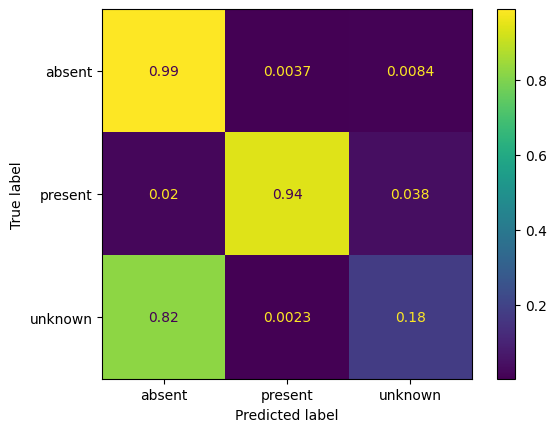

In [ ]:
prescence_matrix = sklearn.metrics.confusion_matrix(
    expanded_edema_df['Edema_Presence'],
    expanded_edema_df['llm_predictions_Presence'],
    labels=['absent', 'present', 'unknown'],
    normalize='true'
)

pres_disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=prescence_matrix,
    display_labels=['absent', 'present', 'unknown']
)
pres_disp.plot()

In [ ]:
print(expanded_edema_df['Edema_Severity'].unique())
print(50 * '=')
print(expanded_edema_df['llm_predictions_Severity'].unique())

['moderate' 'unknown' 'NA' 'mild' 'trace' 'severe']
['unknown' 'NA' 'mild' nan 'trace' 'moderate' 'severe']


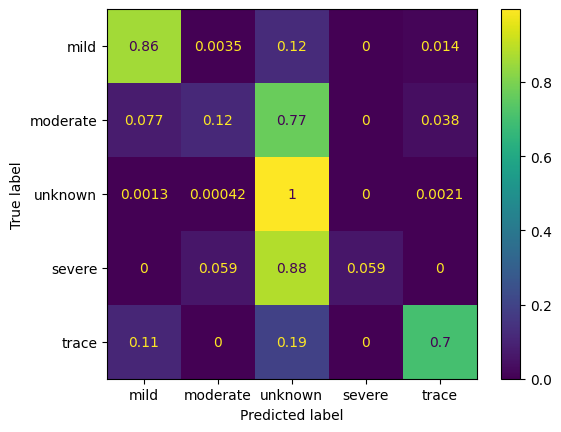

In [ ]:
def map_results_for_severity(label: str) -> str:
    # Severity labels expected by the confusion matrix
    VALID_SEVERITY_LABELS = ['mild', 'moderate', 'unknown', 'severe', 'trace']
    # Mapping for common variations or special cases
    SEVERITY_MAP = {
        "na": "unknown", # Map 'NA' to 'unknown'
        "n/a": "unknown",
        "none": "unknown", # Assuming 'none' for severity also implies unknown or not applicable
    }

    if pd.isna(label): # Handle NaN values (float)
        return 'unknown'
    raw_label = str(label).lower().strip() # Convert to string and normalize

    if raw_label in SEVERITY_MAP:
        return SEVERITY_MAP[raw_label]
    elif raw_label in VALID_SEVERITY_LABELS:
        return raw_label
    else:
        return 'unknown' # Default for any unmapped or unexpected values

# Apply the mapping function to both 'Severity' columns
expanded_edema_df['Edema_Severity_Cleaned'] = expanded_edema_df['Edema_Severity'].apply(map_results_for_severity)
expanded_edema_df['llm_predictions_Severity_Cleaned'] = expanded_edema_df['llm_predictions_Severity'].apply(map_results_for_severity)

severity_matrix = sklearn.metrics.confusion_matrix(
    expanded_edema_df['Edema_Severity_Cleaned'],
    expanded_edema_df['llm_predictions_Severity_Cleaned'],
    labels=['mild' ,'moderate', 'unknown', 'severe', 'trace'],
    normalize='true'
)

sev_disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=severity_matrix,
    display_labels=['mild', 'moderate','unknown', 'severe' ,'trace']
)

sev_disp.plot()

In [ ]:
import os, json, joblib
from datetime import datetime

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR = f"./saved_runs/mediphi_eval_{RUN_ID}"
os.makedirs(OUTDIR, exist_ok=True)

# 1) Save raw generation strings (so you never re-run model.generate)
# predictions_out exists in your notebook
with open(f"{OUTDIR}/predictions_raw.jsonl", "w") as f:
    for acc, rep, raw in zip(test_df.get("Accession", [None]*len(test_df)),
                             test_df["Radiologist_Report"],
                             predictions_out):
        f.write(json.dumps({
            "Accession": acc,
            "Radiologist_Report": rep,
            "raw_model_output": raw
        }) + "\n")

# 2) Save parsed dict outputs + the test_df itself
test_df.to_parquet(f"{OUTDIR}/test_df_with_llm_predictions.parquet", index=False)

# 3) Save the expanded eval table you built (expanded_edema_df)
expanded_edema_df.to_parquet(f"{OUTDIR}/expanded_edema_df.parquet", index=False)

# 4) Save confusion matrices (numpy arrays)
import numpy as np
np.save(f"{OUTDIR}/presence_confusion.npy", prescence_matrix)
np.save(f"{OUTDIR}/severity_confusion.npy", severity_matrix)

print("Saved run artifacts to:", OUTDIR)


Saved run artifacts to: ./saved_runs/mediphi_eval_20260213_005756


In [ ]:
import pandas as pd, numpy as np

OUTDIR = "./saved_runs/mediphi_eval_20260213_005756" # Corrected path to the saved artifacts

test_df = pd.read_parquet(f"{OUTDIR}/test_df_with_llm_predictions.parquet")
expanded_edema_df = pd.read_parquet(f"{OUTDIR}/expanded_edema_df.parquet")
prescence_matrix = np.load(f"{OUTDIR}/presence_confusion.npy")
severity_matrix  = np.load(f"{OUTDIR}/severity_confusion.npy")

In [ ]:
import json, pandas as pd

pred_rows = []
with open(f"{OUTDIR}/predictions_raw.jsonl", "r") as f:
    for line in f:
        pred_rows.append(json.loads(line))

pred_df = pd.DataFrame(pred_rows)
pred_df.head()


,Accession,Radiologist_Report,raw_model_output
0,53314577,"FINDINGS:\nLines and Tubes: Impella, AICD, Swa...","{'Presence': 'present', 'Severity': 'unknown',..."
1,54209096,FINDINGS:\nSee IMPRESSION.\n\nIMPRESSION: Devi...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
2,52528408,FINDINGS:\nLines and Tubes: None\nMediastinum:...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
3,53819581,FINDINGS:\nSee impression.\n\nIMPRESSION: Stab...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
4,54001618,FINDINGS:\nSee impression\n\nIMPRESSION: Stabl...,"{'Presence': 'present', 'Severity': 'mild', 'C..."


In [ ]:
if "Accession" in test_df.columns and "Accession" in pred_df.columns:
    test_with_raw = test_df.merge(pred_df[["Accession","raw_model_output"]], on="Accession", how="left")
else:
    # fallback: align by row order (only if you saved in same order)
    test_with_raw = test_df.copy()
    test_with_raw["raw_model_output"] = pred_df["raw_model_output"].values

test_with_raw[["Radiologist_Report","raw_model_output"]].head()


,Radiologist_Report,raw_model_output
0,"FINDINGS:\nLines and Tubes: Impella, AICD, Swa...","{'Presence': 'present', 'Severity': 'unknown',..."
1,FINDINGS:\nSee IMPRESSION.\n\nIMPRESSION: Devi...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
2,FINDINGS:\nLines and Tubes: None\nMediastinum:...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
3,FINDINGS:\nSee impression.\n\nIMPRESSION: Stab...,"{'Presence': 'absent', 'Severity': 'NA', 'Chan..."
4,FINDINGS:\nSee impression\n\nIMPRESSION: Stabl...,"{'Presence': 'present', 'Severity': 'mild', 'C..."


In [ ]:
expanded_edema_df.columns
expanded_edema_df.head(3)


,Edema_Presence,Edema_Severity,Edema_Change,llm_predictions_Presence,llm_predictions_Severity,llm_predictions_Change,Edema_Severity_Cleaned,llm_predictions_Severity_Cleaned
0,present,moderate,stable,present,unknown,unknown,moderate,unknown
1,unknown,unknown,unknown,absent,NA,NA,unknown,unknown
2,absent,NA,NA,absent,NA,NA,unknown,unknown


In [ ]:
import os, glob

paths = glob.glob("./pneumonia_lora_outputs/checkpoint-*")
print("Found checkpoints:", len(paths))
print("\n".join(paths[:5]))

# check key adapter files in the latest checkpoint
if paths:
    latest = sorted(paths, key=lambda p: int(p.split("-")[-1]))[-1]
    print("\nLatest:", latest)
    print("adapter_config.json exists:", os.path.exists(os.path.join(latest, "adapter_config.json")))
    print("adapter_model.safetensors exists:", os.path.exists(os.path.join(latest, "adapter_model.safetensors")))
    print("adapter_model.bin exists:", os.path.exists(os.path.join(latest, "adapter_model.bin")))


Found checkpoints: 0



In [ ]:
import os, glob

print("CWD:", os.getcwd())

# What folders exist?
print("Top-level dirs:", [p for p in os.listdir(".") if os.path.isdir(p)][:50])

# Anything under your output dir?
outdir = "./pneumonia_lora_outputs"
print("outdir exists:", os.path.exists(outdir))
if os.path.exists(outdir):
    print("outdir contents:", os.listdir(outdir)[:50])

# Any checkpoints anywhere?
print("checkpoints:", glob.glob("./**/checkpoint-*", recursive=True)[:20])


CWD: /content
Top-level dirs: ['.config', 'drive', 'mediphi-lora', 'saved_runs', 'sample_data']
outdir exists: False
checkpoints: ['./mediphi-lora/checkpoint-189', './mediphi-lora/checkpoint-126']


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

BASE_MODEL = "microsoft/MediPhi"  # must be the same base model you trained
LORA_DIR   = "./mediphi-lora/checkpoint-189"  # or checkpoint-126

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto"
)

model = PeftModel.from_pretrained(base_model, LORA_DIR)
model.eval();


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import json

with open(f"{LORA_DIR}/adapter_config.json", "r") as f:
    cfg = json.load(f)

print(cfg.get("base_model_name_or_path"))


microsoft/MediPhi


In [ ]:
import os
ckpt = "./mediphi-lora/checkpoint-189"
print("exists:", os.path.exists(ckpt))
print("files:", os.listdir(ckpt)[:20])


exists: True
files: ['tokenizer.model', 'README.md', 'adapter_model.safetensors', 'tokenizer_config.json', 'added_tokens.json', 'special_tokens_map.json', 'training_args.bin', 'trainer_state.json', 'adapter_config.json', 'scaler.pt', 'optimizer.pt', 'scheduler.pt', 'rng_state.pth', 'tokenizer.json', 'chat_template.jinja']


In [ ]:
from huggingface_hub import login
login()

In [ ]:
HF_REPO = "brianthuynh/mediphi-LoRA-Edema"
tuned_model.push_to_hub(HF_REPO)
tokenizer.push_to_hub(HF_REPO)

## Applying SHAP to LLM responses


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

BASE_MODEL_ID = "microsoft/MediPhi"
ADAPTER_ID_OR_PATH = "brianthuynh/mediphi-LoRA-Edema"   # OR "./mediphi-lora/checkpoint-96"

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# IMPORTANT FOR TRAINING:
# - Do NOT load in float16
# - Do NOT use device_map="auto" for Trainer training (keep it simple)
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_ID)
base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.config.use_cache = False  # important for training

# Attach LoRA adapter and make it trainable
model = PeftModel.from_pretrained(base_model, ADAPTER_ID_OR_PATH, is_trainable=True)

# Ensure fp32 params so AMP(fp16=True) doesn't throw "Attempting to unscale FP16 gradients"
model = model.float()

print("Model loaded:", type(model))
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ---- subset to 25 reports for a fast run ----
def take_n(ds, n=25):
    # HF datasets.Dataset
    if hasattr(ds, "select"):
        return ds.select(range(min(n, len(ds))))
    # torch Dataset
    try:
        from torch.utils.data import Subset
        return Subset(ds, list(range(min(n, len(ds)))))
    except Exception:
        raise ValueError("Unsupported dataset type for subsetting.")

train_25 = take_n(train_dataset, 25)
val_25   = take_n(val_dataset, 25)

print("train_25:", len(train_25), "val_25:", len(val_25))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded: <class 'peft.peft_model.PeftModelForCausalLM'>
Trainable params: 12582912
train_25: 25 val_25: 25


In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./mediphi-lora-25",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,                 # AMP mixed precision (safe because model is fp32)
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="none",
)

# Correct collator for CausalLM SFT
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100,
    return_tensors="pt",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_25,
    eval_dataset=val_25,
    data_collator=data_collator,
)

trainer.train()

# Save the adapter (PEFT will save adapter weights here)
trainer.model.save_pretrained("./mediphi-lora-25/final_adapter")
tokenizer.save_pretrained("./mediphi-lora-25/final_adapter")

print("Saved adapter to ./mediphi-lora-25/final_adapter")


Epoch,Training Loss,Validation Loss
1,No log,0.034834
2,No log,0.034147
3,0.019600,0.034794


Saved adapter to ./mediphi-lora-25/final_adapter


In [ ]:
import pandas as pd
import numpy as np
import ast
import re

PRESENCE_LABELS = ["absent", "present", "unknown"]
SEVERITY_LABELS = ["mild", "moderate", "severe", "trace", "unknown"]

def parse_edema(x):
    """
    Returns (presence, severity) from many possible formats.
    """
    presence, severity = None, None

    # 1) if it's already a dict
    if isinstance(x, dict):
        # normalize keys
        lower = {str(k).lower(): v for k, v in x.items()}
        # try common key names
        for k in ["presence", "edema_presence", "edema presence"]:
            if k in lower:
                presence = str(lower[k]).lower()
        for k in ["severity", "edema_severity", "edema severity"]:
            if k in lower:
                severity = str(lower[k]).lower()

    # 2) if it's a tuple/list
    elif isinstance(x, (list, tuple)) and len(x) >= 1:
        presence = str(x[0]).lower()
        if len(x) >= 2:
            severity = str(x[1]).lower()

    # 3) if it's a string (maybe dict-like)
    elif isinstance(x, str):
        s = x.strip()

        # attempt to parse dict literal string safely
        if s.startswith("{") and s.endswith("}"):
            try:
                d = ast.literal_eval(s)
                if isinstance(d, dict):
                    return parse_edema(d)
            except Exception:
                pass

        sl = s.lower()
        # normalize separators
        sl = re.sub(r"[\[\]\(\)]", " ", sl)
        sl = sl.replace("/", " ").replace(",", " ").replace(";", " ").replace("|", " ")
        sl = sl.replace("_", " ").replace("-", " ")

        tokens = [t for t in sl.split() if t]

        # presence token
        for t in tokens:
            if t in PRESENCE_LABELS:
                presence = t
                break

        # severity token
        for t in tokens:
            if t in SEVERITY_LABELS:
                severity = t
                break

        # handle cases like "present mild" where both exist
        # if only one token and it's a severity, presence might still be missing
        # leave missing as unknown below

    # default unknowns if missing
    if presence not in PRESENCE_LABELS:
        presence = "unknown"
    if severity not in SEVERITY_LABELS:
        severity = "unknown"

    return presence, severity


# Apply to dataframe
expanded = test_df.copy()
expanded[["Edema_Presence", "Edema_Severity"]] = expanded["Edema"].apply(
    lambda x: pd.Series(parse_edema(x))
)

print(expanded[["Edema", "Edema_Presence", "Edema_Severity"]].head(10))
print("\nPresence value counts:\n", expanded["Edema_Presence"].value_counts())
print("\nSeverity value counts:\n", expanded["Edema_Severity"].value_counts())


                                                Edema Edema_Presence  \
2   {'Presence': 'present', 'Severity': 'moderate'...        present   
3   {'Presence': 'unknown', 'Severity': 'unknown',...        unknown   
4   {'Presence': 'absent', 'Severity': 'NA', 'Chan...         absent   
5   {'Presence': 'unknown', 'Severity': 'unknown',...        unknown   
6   {'Presence': 'present', 'Severity': 'mild', 'C...        present   
7   {'Presence': 'unknown', 'Severity': 'unknown',...        unknown   
8   {'Presence': 'unknown', 'Severity': 'unknown',...        unknown   
9   {'Presence': 'unknown', 'Severity': 'unknown',...        unknown   
10  {'Presence': 'absent', 'Severity': 'NA', 'Chan...         absent   
11  {'Presence': 'present', 'Severity': 'mild', 'C...        present   

   Edema_Severity  
2        moderate  
3         unknown  
4         unknown  
5         unknown  
6            mild  
7         unknown  
8         unknown  
9         unknown  
10        unknown  
11     

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

     Edema_Presence pred_presence Edema_Severity pred_severity
598         present       present           mild          mild
1468         absent        absent        unknown      moderate
2886         absent       present        unknown      moderate
2446        unknown       present        unknown        severe
3484         absent       present        unknown          mild
1540         absent       unknown        unknown       unknown
2796         absent        absent        unknown      moderate
3361        present       present       moderate        severe
1303         absent       unknown        unknown          mild
1536         absent       unknown        unknown       unknown


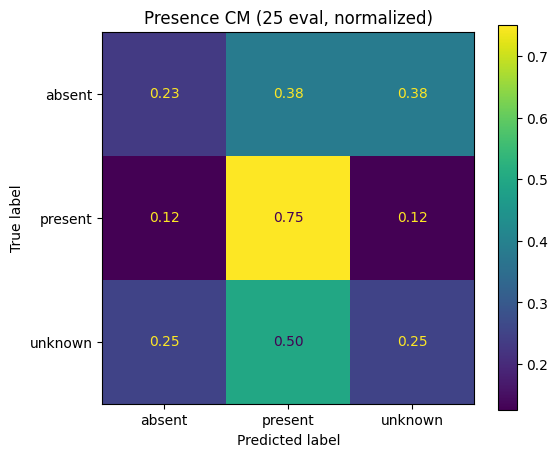

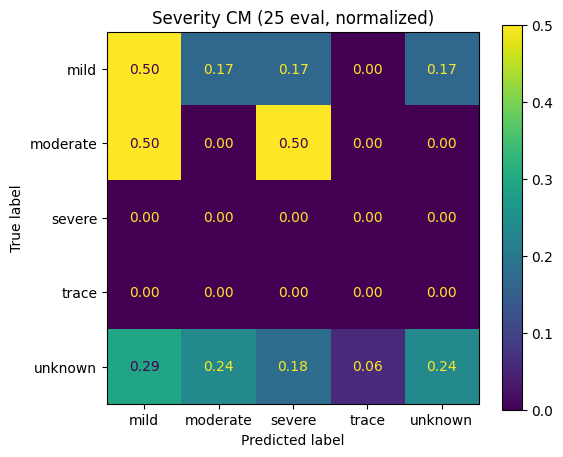

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 1/25 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 3/25 [01:17<06:41, 18.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 4/25 [01:53<09:00, 25.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 5/25 [02:29<09:51, 29.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 6/25 [03:06<10:07, 31.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 7/25 [03:43<10:08, 33.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 8/25 [04:20<09:49, 34.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 9/25 [04:56<09:23, 35.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 10/25 [05:33<08:54, 35.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 11/25 [06:09<08:22, 35.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 12/25 [06:45<07:48, 36.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 13/25 [07:22<07:13, 36.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 14/25 [07:59<06:40, 36.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 15/25 [08:36<06:05, 36.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 16/25 [09:12<05:29, 36.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 17/25 [09:49<04:51, 36.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 18/25 [10:25<04:15, 36.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 19/25 [11:01<03:38, 36.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 20/25 [11:38<03:02, 36.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 21/25 [12:14<02:25, 36.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 22/25 [12:50<01:48, 36.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 23/25 [13:27<01:12, 36.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 24/25 [14:03<00:36, 36.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 25/25 [14:40<00:00, 36.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 26it [15:17, 36.69s/it]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 1/25 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 3/25 [02:02<11:06, 30.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 4/25 [03:03<15:07, 43.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 5/25 [04:05<16:41, 50.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 6/25 [05:07<17:10, 54.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 7/25 [06:11<17:12, 57.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 8/25 [07:13<16:40, 58.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 9/25 [08:14<15:54, 59.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 10/25 [09:16<15:04, 60.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 11/25 [10:18<14:10, 60.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 12/25 [11:19<13:11, 60.89s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 13/25 [12:20<12:12, 61.07s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 14/25 [13:23<11:17, 61.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 15/25 [14:26<10:20, 62.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 16/25 [15:28<09:18, 62.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 17/25 [16:30<08:14, 61.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 18/25 [17:31<07:12, 61.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  76%|███████▌  | 19/25 [18:33<06:10, 61.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 20/25 [19:35<05:08, 61.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 21/25 [20:36<04:06, 61.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 22/25 [21:38<03:04, 61.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 23/25 [22:39<02:03, 61.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 24/25 [23:39<01:01, 61.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 25/25 [24:40<00:00, 61.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 26it [25:41, 61.67s/it]

Example 0 | true: present mild | pred: present mild


In [ ]:
!pip -q install shap

import numpy as np
import pandas as pd
import shap
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

REPORT_COL = "Radiologist_Report"
TRUE_PRES_COL = "Edema_Presence"
TRUE_SEV_COL  = "Edema_Severity"

# Pick 25 eval samples (use your own df; example uses test_df)
eval_df = expanded.sample(n=min(25, len(expanded)), random_state=42).copy()

# ---- Reload base+adapter for inference FAST (fp16 + device_map) ----
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto",
)
tuned_model = PeftModel.from_pretrained(
    base_model,
    "./mediphi-lora-25/final_adapter",   # the adapter you just trained
    device_map="auto",
)
tuned_model.eval()

# ---- label candidates ----
PRESENCE_LABELS = ["absent", "present", "unknown"]
SEVERITY_LABELS = ["mild", "moderate", "severe", "trace", "unknown"]

PROMPT_PRESENCE = (
    "Read the radiology report and classify pulmonary edema presence.\n"
    "Answer with exactly one word from: absent, present, unknown.\n\nReport:\n"
)
PROMPT_SEVERITY = (
    "Read the radiology report and classify pulmonary edema severity.\n"
    "Answer with exactly one word from: mild, moderate, severe, trace, unknown.\n\nReport:\n"
)

@torch.no_grad()
def _label_logprobs_for_reports(reports, labels, prompt_text, batch_size=4):
    device = tuned_model.device
    label_token_ids = [tokenizer.encode(" " + lab, add_special_tokens=False) for lab in labels]
    label_lens = [len(x) for x in label_token_ids]

    all_logprobs = []
    for start in range(0, len(reports), batch_size):
        batch = [r if isinstance(r, str) else "" for r in reports[start:start+batch_size]]

        messages = [[{"role":"user", "content": prompt_text + rep}] for rep in batch]
        base = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True,
            tokenize=True, return_dict=True,
            return_tensors="pt", padding=True,
        )
        base_ids = base["input_ids"].to(device)
        base_mask = base["attention_mask"].to(device)
        base_lens = base_mask.sum(dim=1).tolist()

        batch_label_logprobs = torch.zeros((len(batch), len(labels)), device=device)

        for li, lab_ids in enumerate(label_token_ids):
            lab_ids_t = torch.tensor(lab_ids, dtype=torch.long, device=device)

            seqs, masks = [], []
            for i in range(len(batch)):
                L = int(base_lens[i])
                seq = torch.cat([base_ids[i, :L], lab_ids_t], dim=0)
                seqs.append(seq)
                masks.append(torch.ones_like(seq, device=device))

            padded = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_token_id)
            attn   = torch.nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

            out = tuned_model(input_ids=padded, attention_mask=attn)
            logp = torch.log_softmax(out.logits, dim=-1)

            for i in range(len(batch)):
                base_L = int(base_lens[i])
                lp_sum = 0.0
                for j in range(label_lens[li]):
                    pred_pos = (base_L - 1) + j
                    tok_id = lab_ids[j]
                    lp_sum += logp[i, pred_pos, tok_id].item()
                batch_label_logprobs[i, li] = lp_sum

        all_logprobs.append(batch_label_logprobs.detach().cpu())

    return torch.cat(all_logprobs, dim=0).numpy()

def predict_labels_and_probs(reports, labels, prompt_text, batch_size=4):
    logprobs = _label_logprobs_for_reports(reports, labels, prompt_text, batch_size=batch_size)
    x = logprobs - logprobs.max(axis=1, keepdims=True)
    probs = np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)
    pred = [labels[i] for i in probs.argmax(axis=1)]
    return pred, probs

# ---- Run predictions on 25 ----
reports = eval_df[REPORT_COL].astype(str).tolist()
pred_presence, prob_presence = predict_labels_and_probs(reports, PRESENCE_LABELS, PROMPT_PRESENCE)
pred_severity,  prob_severity  = predict_labels_and_probs(reports, SEVERITY_LABELS,  PROMPT_SEVERITY)

eval_df["pred_presence"] = pred_presence
eval_df["pred_severity"] = pred_severity

print(eval_df[[TRUE_PRES_COL, "pred_presence", TRUE_SEV_COL, "pred_severity"]].head(10))

# ---- Confusion matrices ----
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, values_format=".2f", colorbar=True)
    ax.set_title(title)
    plt.show()

plot_cm(eval_df[TRUE_PRES_COL], eval_df["pred_presence"], PRESENCE_LABELS, "Presence CM (25 eval, normalized)")
plot_cm(eval_df[TRUE_SEV_COL],  eval_df["pred_severity"],  SEVERITY_LABELS,  "Severity CM (25 eval, normalized)")

# ---- SHAP explainability (token-level) ----
def make_predict_fn(labels, prompt_text):
    def _predict(text_list):
        _, probs = predict_labels_and_probs(list(text_list), labels, prompt_text, batch_size=4)
        return probs
    return _predict

masker = shap.maskers.Text(tokenizer)
expl_presence = shap.Explainer(make_predict_fn(PRESENCE_LABELS, PROMPT_PRESENCE), masker, output_names=PRESENCE_LABELS)
expl_severity = shap.Explainer(make_predict_fn(SEVERITY_LABELS,  PROMPT_SEVERITY),  masker, output_names=SEVERITY_LABELS)

shap_presence = expl_presence(reports)
shap_severity = expl_severity(reports)

# Visualize one example (pick index)
i = 0
print("Example", i, "| true:", eval_df[TRUE_PRES_COL].iloc[i], eval_df[TRUE_SEV_COL].iloc[i],
      "| pred:", eval_df["pred_presence"].iloc[i], eval_df["pred_severity"].iloc[i])

p_idx = PRESENCE_LABELS.index(eval_df["pred_presence"].iloc[i])
s_idx = SEVERITY_LABELS.index(eval_df["pred_severity"].iloc[i])

shap.plots.text(shap_presence[i, :, p_idx])
shap.plots.text(shap_severity[i, :, s_idx])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _norm_tok(tok: str) -> str:
    t = str(tok)
    return t.replace("▁", " ").replace("Ġ", " ").strip()

def shap_vals_for_example(shap_exp, i, class_idx=None):
    """
    Returns 1D token SHAP values for example i.
    Works for ragged SHAP storage (object arrays).
    """
    v = shap_exp.values[i]   # <-- element array for this example
    v = np.asarray(v)

    if v.ndim == 1:
        # (tokens,)
        return v

    if v.ndim == 2:
        # (tokens, classes)
        if class_idx is None:
            raise ValueError("This explainer produced per-class SHAP (tokens, classes). Provide class_idx.")
        return v[:, class_idx]

    raise ValueError(f"Unexpected per-example SHAP shape: {v.shape}")

def top_tokens_for_example(shap_exp, i, class_idx=None, top_k=20, use_abs=True):
    toks = [_norm_tok(t) for t in np.asarray(shap_exp.data[i]).tolist()]
    vals = shap_vals_for_example(shap_exp, i, class_idx=class_idx)

    m = min(len(toks), len(vals))
    pairs = [(toks[j], float(vals[j])) for j in range(m) if toks[j] != ""]

    key = (lambda x: abs(x[1])) if use_abs else (lambda x: x[1])
    return sorted(pairs, key=key, reverse=True)[:top_k]

def plot_token_bar(pairs, title):
    tokens = [t for t, _ in pairs][::-1]
    values = [v for _, v in pairs][::-1]

    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(tokens))))
    ax.barh(tokens, values)
    ax.axvline(0, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("SHAP contribution (signed)")
    plt.tight_layout()
    plt.show()


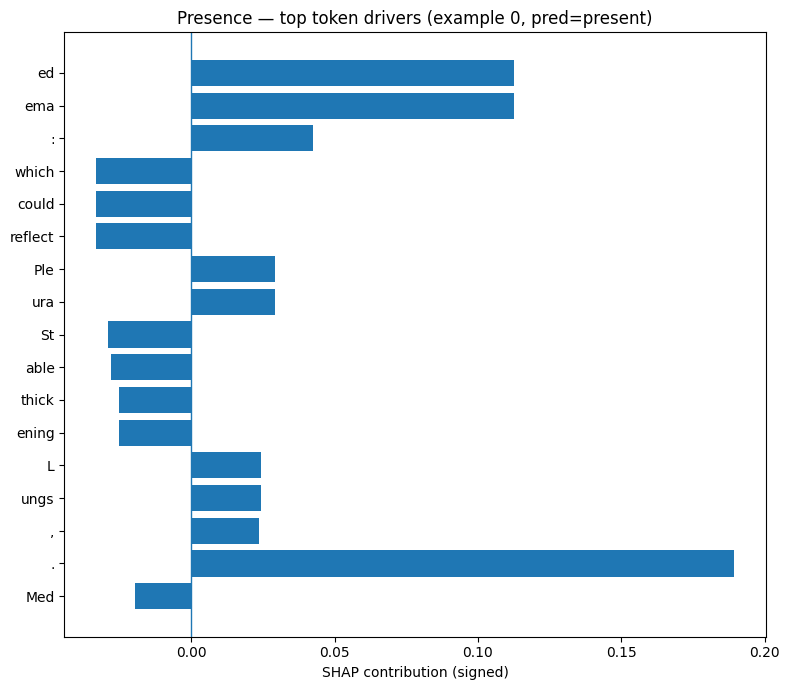

In [ ]:
i = 0
pred_p = eval_df["pred_presence"].iloc[i]     # e.g., "present"
p_idx = PRESENCE_LABELS.index(pred_p)

pairs_p = top_tokens_for_example(shap_presence, i, class_idx=p_idx, top_k=20)
plot_token_bar(pairs_p, f"Presence — top token drivers (example {i}, pred={pred_p})")


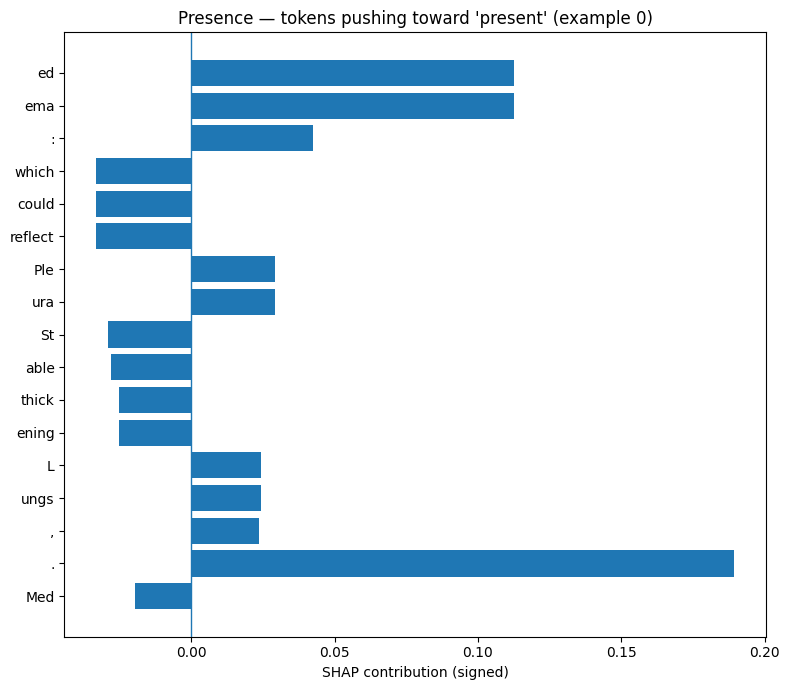

In [ ]:
i = 0
p_idx = PRESENCE_LABELS.index("present")

pairs_p = top_tokens_for_example(shap_presence, i, class_idx=p_idx, top_k=20)
plot_token_bar(pairs_p, f"Presence — tokens pushing toward 'present' (example {i})")


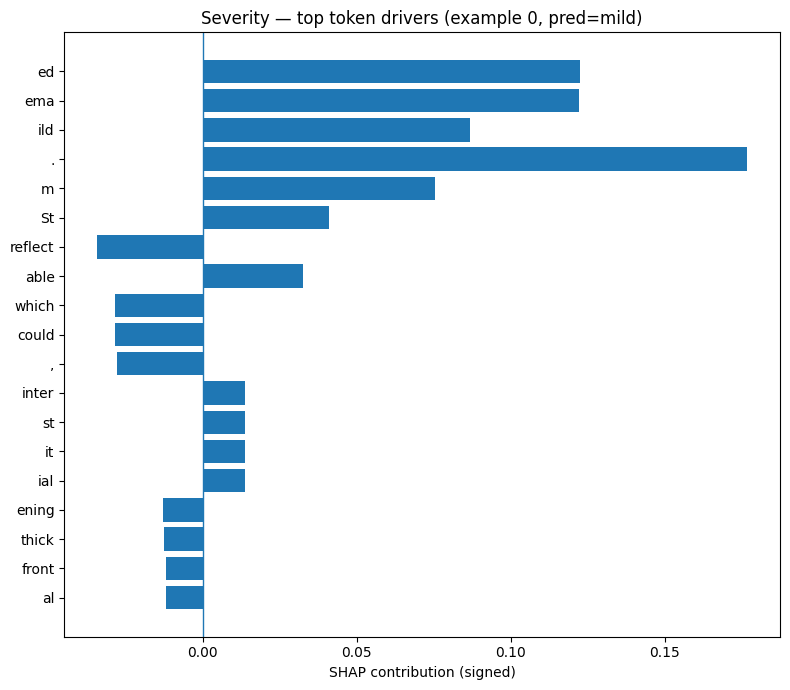

In [ ]:
i = 0
pred_s = eval_df["pred_severity"].iloc[i]      # e.g., "mild"
s_idx = SEVERITY_LABELS.index(pred_s)

pairs_s = top_tokens_for_example(shap_severity, i, class_idx=s_idx, top_k=20)
plot_token_bar(pairs_s, f"Severity — top token drivers (example {i}, pred={pred_s})")


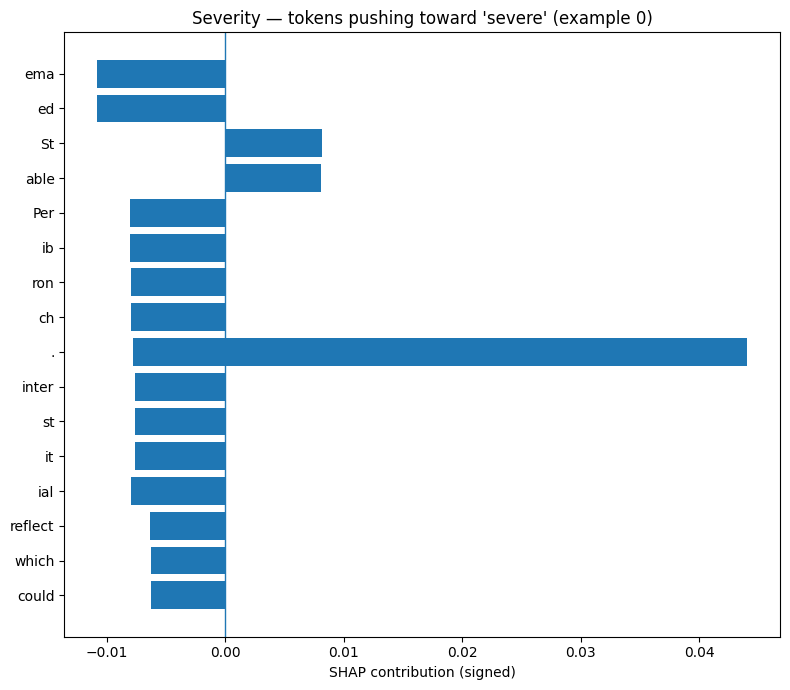

In [ ]:
fixed_class = "severe"   # choose: mild, moderate, severe, trace, unknown
s_idx = SEVERITY_LABELS.index(fixed_class)

i = 0  # which report to visualize
pairs = top_tokens_for_example(shap_severity, i, class_idx=s_idx, top_k=20)
plot_token_bar(pairs, f"Severity — tokens pushing toward '{fixed_class}' (example {i})")


Accession: 53375476
Report:
 FINDINGS:
Lines and Tubes: Interval removal a left-sided dual chamber pacer device, with interval placement of a single lead right upper chest wall pacer device with lead projecting over the right atrium where it takes an acute inferior course, presumably through the tricuspid valve, with tip projecting over the base of the right ventricle.  Mediastinum: The cardiomediastinal silhouette is stably enlarged. Status post TAVR  Lungs: Peribronchial thickening.  Pleura: There may be a small pleural effusion  Bones and soft tissues: Unchanged    

IMPRESSION: Interval removal a left-sided dual chamber pacer device and interval placement of a single chamber pacemaker with the tip projecting over the right ventricle on the frontal view.    Peribronchial thickening which could reflect mild intersti ...



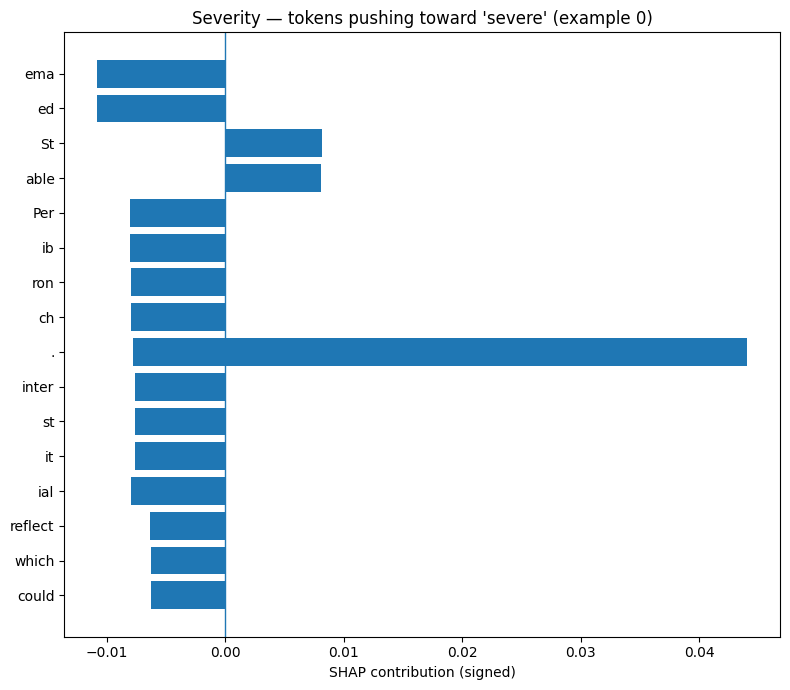

In [ ]:
i = 0  # choose the row in eval_df/reports

fixed_class = "severe"
s_idx = SEVERITY_LABELS.index(fixed_class)

print("Accession:", eval_df["Accession"].iloc[i] if "Accession" in eval_df.columns else "(no Accession col)")
print("Report:\n", reports[i][:800], "...\n")

# Inline text explanation (best for humans)
shap.plots.text(shap_severity[i, :, s_idx])

# Bar chart tokens (what you already did)
pairs = top_tokens_for_example(shap_severity, i, class_idx=s_idx, top_k=20)
plot_token_bar(pairs, f"Severity — tokens pushing toward '{fixed_class}' (example {i})")


## Hidden Embedding Similarity Analysis
The clean approach is:

Run your fine-tuned model on the report (forward pass, no generation)

Get the last hidden state (a vector per token)

Convert token vectors → word vectors by merging subword pieces into words

Build a label vector for each class (e.g., “present”, “absent”, “severe”, “mild”) using the same model hidden states

Score each word by cosine similarity to the label vector (or a difference vector like present − absent)

Visualize top contributing words.


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

BASE_MODEL_ID = "microsoft/MediPhi"
ADAPTER_PATH = "./mediphi-lora-trained"   # or your checkpoint folder / HF adapter repo

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.float16,
    device_map="auto",
)
tuned_model = PeftModel.from_pretrained(base, ADAPTER_PATH, device_map="auto")
tuned_model.eval()


Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Phi3ForCausalLM(
      (model): Phi3Model(
        (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
        (layers): ModuleList(
          (0-31): 32 x Phi3DecoderLayer(
            (self_attn): Phi3Attention(
              (o_proj): lora.Linear(
                (base_layer): Linear(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (qkv_proj

In [ ]:
import numpy as np
import re
import torch

def cosine(a, b, eps=1e-12):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(np.dot(a, b))

@torch.no_grad()
def embed_text_tokens(text, model, tokenizer, max_length=1024):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=False,
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    out = model(
        **inputs,
        output_hidden_states=True,   # <-- key change
        return_dict=True
    )

    # hidden_states is a tuple: (embeddings, layer1, ..., last_layer)
    last_h = out.hidden_states[-1][0]   # shape: (T, H)
    vecs = last_h.detach().float().cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].detach().cpu().tolist())
    return tokens, vecs


In [ ]:
def tokens_to_words(tokens, vecs):
    words, word_vecs = [], []
    cur_word, cur_vecs = "", []

    for tok, v in zip(tokens, vecs):
        if tok in ["<s>", "</s>", "<pad>"]:
            continue

        # SentencePiece boundary
        if tok.startswith("▁"):
            if cur_vecs:
                words.append(cur_word)
                word_vecs.append(np.mean(cur_vecs, axis=0))
            cur_word = tok[1:]
            cur_vecs = [v]
        else:
            cur_word += tok
            cur_vecs.append(v)

    if cur_vecs:
        words.append(cur_word)
        word_vecs.append(np.mean(cur_vecs, axis=0))

    cleaned_words, cleaned_vecs = [], []
    for w, vv in zip(words, word_vecs):
        w2 = re.sub(r"\s+", " ", w).strip()
        if w2 and w2 != "<unk>":
            cleaned_words.append(w2)
            cleaned_vecs.append(vv)

    return cleaned_words, np.stack(cleaned_vecs, axis=0)


In [ ]:
def label_vector(label_text, model, tokenizer):
    toks, vecs = embed_text_tokens(label_text, model, tokenizer, max_length=256)
    words, wvecs = tokens_to_words(toks, vecs)
    return np.mean(wvecs, axis=0)

# Presence direction
v_present = label_vector("pulmonary edema is present", tuned_model, tokenizer)
v_absent  = label_vector("pulmonary edema is absent", tuned_model, tokenizer)
v_presence_dir = v_present - v_absent

# Severity direction
v_severe = label_vector("severe pulmonary edema", tuned_model, tokenizer)
v_mild   = label_vector("mild pulmonary edema", tuned_model, tokenizer)
v_severity_dir = v_severe - v_mild


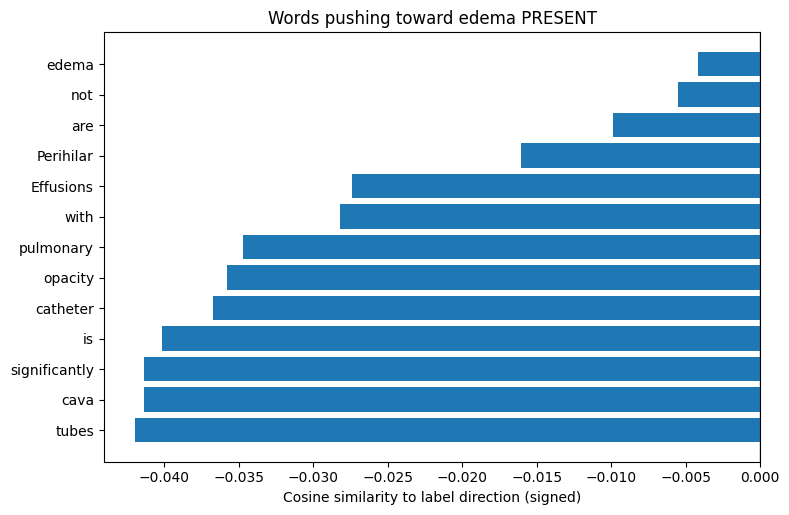

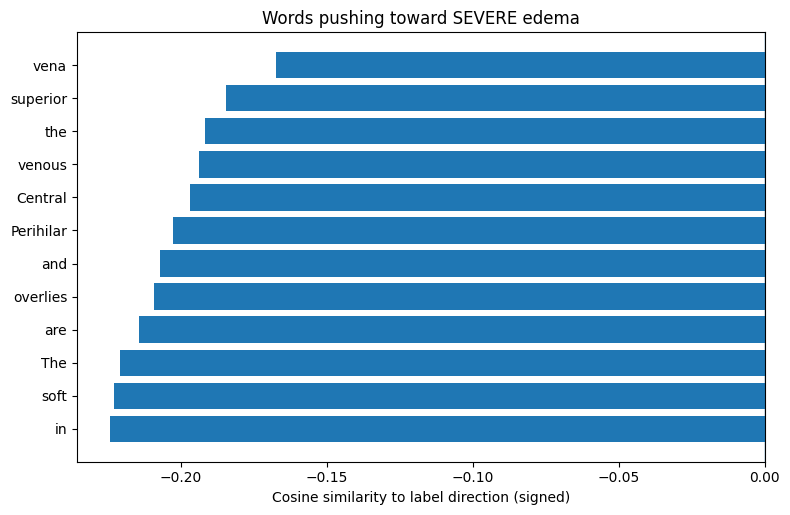

In [ ]:
def score_words(report, direction_vec, model, tokenizer, top_k=20):
    toks, vecs = embed_text_tokens(report, model, tokenizer, max_length=1024)
    words, wvecs = tokens_to_words(toks, vecs)

    scored = [(w, cosine(v, direction_vec)) for w, v in zip(words, wvecs)]
    scored_sorted = sorted(scored, key=lambda x: x[1], reverse=True)
    return scored_sorted[:top_k], scored_sorted[-top_k:]

import matplotlib.pyplot as plt

def plot_word_scores(pairs, title, n=15):
    pairs = pairs[:n]
    ws = [w for w,_ in pairs][::-1]
    vs = [s for _,s in pairs][::-1]
    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(ws))))
    ax.barh(ws, vs)
    ax.axvline(0, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Cosine similarity to label direction (signed)")
    plt.tight_layout()
    plt.show()

# pick a report index
i = 0
report = test_df["Radiologist_Report"].iloc[i]

top_p, _ = score_words(report, v_presence_dir, tuned_model, tokenizer, top_k=20)
top_s, _ = score_words(report, v_severity_dir, tuned_model, tokenizer, top_k=20)

plot_word_scores(top_p, "Words pushing toward edema PRESENT")
plot_word_scores(top_s, "Words pushing toward SEVERE edema")


## Cosine Similarity Analysis (with tokens of interest)


In [ ]:
import re

REPORT_COL = "Radiologist_Report"

present_kw = [
    r"\bpulmonary edema\b", r"\binterstitial edema\b", r"\bvascular congestion\b",
    r"\bperihilar\b", r"\bCHF\b", r"\bfluid overload\b"
]
absent_kw = [
    r"\bno (pulmonary )?edema\b", r"\bwithout edema\b", r"\bnegative for edema\b"
]
severe_kw = [
    r"\bsevere\b", r"\bmarked\b", r"\bdiffuse\b", r"\bflorid\b", r"\bworsening edema\b"
]

def pick_cases(df, include_patterns, exclude_patterns=None, n=3):
    exclude_patterns = exclude_patterns or []
    mask = df[REPORT_COL].astype(str).apply(
        lambda t: any(re.search(p, t, flags=re.IGNORECASE) for p in include_patterns)
    )
    for p in exclude_patterns:
        mask &= ~df[REPORT_COL].astype(str).str.contains(p, case=False, na=False, regex=True)
    return df[mask].head(n).copy()

best_present = pick_cases(test_df, present_kw, exclude_patterns=absent_kw, n=3)
best_absent  = pick_cases(test_df, absent_kw, n=3)
best_severe  = pick_cases(test_df, severe_kw + present_kw, exclude_patterns=absent_kw, n=3)

print("Best present indices:", list(best_present.index))
print("Best absent indices :", list(best_absent.index))
print("Best severe indices :", list(best_severe.index))


/tmp/ipython-input-2086978164.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask &= ~df[REPORT_COL].astype(str).str.contains(p, case=False, na=False, regex=True)


Best present indices: [2, 3, 6]
Best absent indices : [29, 135, 872]
Best severe indices : [2, 3, 6]


/tmp/ipython-input-2086978164.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask &= ~df[REPORT_COL].astype(str).str.contains(p, case=False, na=False, regex=True)


In [ ]:
TOKENS_OF_INTEREST = [
    "pulmonary edema",
    "vascular congestion",
    "interstitial",
    "perihilar",
    "cardiomegaly",
    "pleural effusion",
    "no edema",
    "without edema"
]


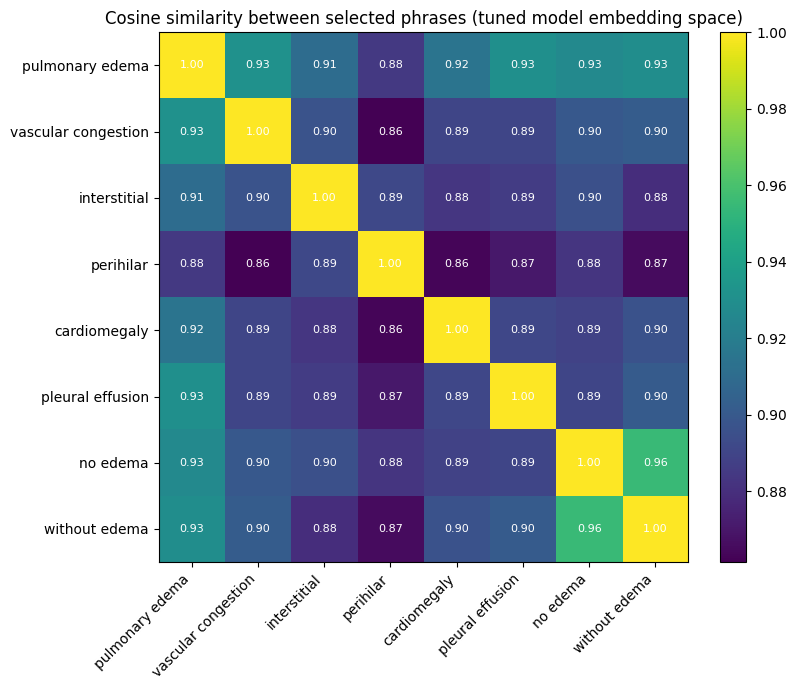

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

# keep gradient colors (choose any matplotlib cmap)
im = ax.imshow(cos_mat, cmap="viridis")   # <- gradient colormap

ax.set_xticks(range(len(terms)))
ax.set_yticks(range(len(terms)))
ax.set_xticklabels(terms, rotation=45, ha="right")
ax.set_yticklabels(terms)
ax.set_title("Cosine similarity between selected phrases (tuned model embedding space)")

# numbers on top of the colors
for i in range(len(terms)):
    for j in range(len(terms)):
        ax.text(j, i, f"{cos_mat[i, j]:.2f}", ha="center", va="center", fontsize=8, color="white")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## Lime (Local Interpretable Model-agnostic Explanations)
explainability method that explains a single prediction by learning a simple surrogate model around that one example.

In [ ]:
!pip -q install lime

import numpy as np
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
@torch.no_grad()
def score_label_continuation(report_text: str, prompt: str, label_text: str, model, tokenizer, max_length=768):
    """
    Returns log-prob (sum) of generating label_text immediately after (prompt + report_text).
    """
    full = prompt + report_text

    # tokenize prefix
    prefix = tokenizer(full, return_tensors="pt", truncation=True, max_length=max_length).to(model.device)

    # tokenize label (no specials)
    lab = tokenizer(label_text, add_special_tokens=False, return_tensors="pt")["input_ids"].to(model.device)

    # concat prefix + label ids
    input_ids = torch.cat([prefix["input_ids"], lab], dim=1)
    attn = torch.ones_like(input_ids).to(model.device)

    out = model(input_ids=input_ids, attention_mask=attn, return_dict=True)
    logits = out.logits  # (1, seq, vocab)

    start = prefix["input_ids"].shape[1]
    # next-token distribution aligned with label tokens
    log_probs = F.log_softmax(logits[:, start-1:-1, :], dim=-1)   # (1, label_len, vocab)
    tok_lp = log_probs.gather(2, lab.unsqueeze(-1)).squeeze(-1)   # (1, label_len)

    return float(tok_lp.sum().item())


def llm_label_probs(reports, prompt, labels, model, tokenizer, max_length=768):
    """
    Returns probs array shape (n_examples, n_labels) for LIME.
    """
    scores = []
    for r in reports:
        s = [score_label_continuation(r, prompt, lab, model, tokenizer, max_length=max_length) for lab in labels]
        scores.append(s)

    scores = np.array(scores, dtype=np.float64)
    # softmax to probs
    scores = scores - scores.max(axis=1, keepdims=True)
    probs = np.exp(scores)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs


In [ ]:
PRESENCE_PROMPT = prompt
PRESENCE_LABELS = ["present", "absent"]

def predict_proba_presence(texts):
    return llm_label_probs(
        texts,
        prompt=PRESENCE_PROMPT,
        labels=PRESENCE_LABELS,
        model=tuned_model,
        tokenizer=tokenizer,
        max_length=768
    )


In [ ]:
SEVERITY_PROMPT = prompt
SEVERITY_LABELS = ["none", "mild", "moderate", "severe"]

def predict_proba_severity(texts):
    return llm_label_probs(
        texts,
        prompt=SEVERITY_PROMPT,
        labels=SEVERITY_LABELS,
        model=tuned_model,
        tokenizer=tokenizer,
        max_length=768
    )


In [ ]:
i = test_df.index[0]
report = test_df.loc[i, "Radiologist_Report"]

explainer_presence = LimeTextExplainer(
    class_names=PRESENCE_LABELS,
    bow=True  # word-level bag-of-words explanation
)

exp = explainer_presence.explain_instance(
    report,
    predict_proba_presence,
    num_features=10,     # top words to show
    num_samples=200      # increase for stability, decrease for speed
)

print("Predicted probs:", dict(zip(PRESENCE_LABELS, predict_proba_presence([report])[0])))
print("\nTop word contributions (LIME):")
for w, weight in exp.as_list():
    print(f"{w:25s} {weight:+.3f}")


KeyboardInterrupt: 

In [ ]:
import re

# Keep negations (clinically important)
KEEP_WORDS = {
    "no", "not", "without", "denies", "deny", "negative", "neg", "nor"
}

# Common filler / boilerplate tokens you don't want to visualize
DROP_WORDS = {
    "findings", "impression", "comparison", "history", "indication",
    "technique", "portable", "ap", "pa", "lateral", "exam", "date",
    "reason", "clinical", "chest", "xray", "radiograph"
}

# A small stopword list (you can expand). Keep KEEP_WORDS even if they appear here.
STOPWORDS = {
    "the","a","an","and","or","but","if","then","this","that","these","those",
    "is","are","was","were","be","been","being",
    "of","to","in","for","on","with","at","by","from","as","it","its",
    "there","here","they","them","their","we","you","your","i",
    "has","have","had","do","does","did","can","could","may","might","will","would",
    "than","also","very"
}

_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?|[0-9]+(?:\.[0-9]+)?")

def lime_domain_tokenizer(text: str):
    raw = _token_re.findall(text.lower())
    toks = []
    for t in raw:
        if t in DROP_WORDS:
            continue
        if t in STOPWORDS and t not in KEEP_WORDS:
            continue
        if len(t) <= 1 and t not in KEEP_WORDS:
            continue
        toks.append(t)
    return toks

